In [1]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import string


In [2]:
model_filename = 'Full_EA'
# batch size = 16, 32
batch_size = 10
premodel_list = ['xlm-roberta-base','xlm-roberta-large']
chosen_premodel = premodel_list[0]

In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if torch.cuda.is_available(): 
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


In [4]:
df_crime = pd.read_csv('../Data/THR_DLR_CLA_V2_Primary_Full_EA.csv')
df_crime

,News Title,News_Intro,News_Desc,News_All,Gambling,Murder,Sexual Abuse,Theft/Burglary,Drug,Battery/Assault,Accident,Non-Crime
0,ตร.นนท์จับหนุ่มแท็กซี่ขโมยเนื้อหมูของร้านตามสั...,ตำรวจ สภ.รัตนาธิเบศร์ จับกุมโชเฟอร์แท็กซี่ตามห...,ตำรวจ สภ.รัตนาธิเบศร์ จับกุมโชเฟอร์แท็กซี่ตามห...,ตร.นนท์จับหนุ่มแท็กซี่ขโมยเนื้อหมูของร้านตามสั...,0,0,0,1,0,0,0,0
1,"ครอบครัว ""ฮ้อแสงชัย"" เชื่อคดี ""เบนซ์ชนฟอร์ด"" จ...",น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุต...,น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุต...,"ครอบครัว ""ฮ้อแสงชัย"" เชื่อคดี ""เบนซ์ชนฟอร์ด"" จ...",0,0,0,0,0,0,1,0
2,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,0,0,0,0,0,0,0,1
3,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,0,1,0,0,1,0,0,0
4,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8562,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,0,0,0,0,0,0,0,1
8563,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,0,1,0,0,1,1,0,0
8564,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,0,0,0,0,0,0,0,1
8565,ในหลวงพระราชทานตราสัญลักษณ์ประจำหน่วยปฏิบัติกา...,พล.ต.ต.จิรภพ ภูริเดช ผบก.ป. พร้อมข้าราชการตำรว...,พล.ต.ต.จิรภพ ภูริเดช ผบก.ป. พร้อมข้าราชการตำรว...,ในหลวงพระราชทานตราสัญลักษณ์ประจำหน่วยปฏิบัติกา...,0,0,0,0,0,0,0,1


In [5]:
def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    # ลบ space
    msg = re.sub(r' ','',msg)
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    return msg

In [6]:
X = df_crime.iloc[:,3:4].values 
y = df_crime.iloc[:, 4:].values
clean_text_arr = []
for i in range(len(X)):
    clean_text = clean_msg(X[i][0])
    temp_arr = []
    temp_arr.append(clean_text)
    clean_text_arr.append(temp_arr)
# print(clean_text_arr)
X = np.array(clean_text_arr)
print(len(y[0]))

8


In [7]:
from skmultilearn.model_selection import iterative_train_test_split

# Set seed for numpy
np.random.seed(42)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_2d, y, test_size=0.2)
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.25)
print(len(y_train[0]))

8


In [8]:
X_train_new = np.array([text for sub in X_train for text in sub]) 
X_test_new = np.array([text for sub in X_test for text in sub]) 
X_val_new = np.array([text for sub in X_val for text in sub]) 

X_train_list = X_train_new.tolist()
X_test_list = X_test_new.tolist()
X_val_list = X_val_new.tolist()

In [9]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained(chosen_premodel)

def preprocessing_for_bert(data):

    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            #text=text_preprocessing(sent),  
            text=sent,
            add_special_tokens=True,        
            max_length=MAX_LEN,
            truncation=True,             
            padding='max_length',         
            #return_tensors='pt',           
            return_attention_mask=True      
        )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [10]:
# test_data = tokenizer(X_train_list[0])
# print(test_data.input_ids)
# print(len(test_data.input_ids))
# print(X_train_list[0])


In [11]:
all_texts = np.concatenate([X_train_list, X_test_list, X_val_list])

In [12]:
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]
# encoded_texts = [tokenizer.encode(sent, add_special_tokens=True,max_length=512,truncation=True) for sent in all_texts]

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


In [13]:
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)
avg_len = sum([len(sent) for sent in encoded_texts]) / len(encoded_texts)
print('Avg length: ', avg_len)

Max length:  3975
Avg length:  619.6041788257266


In [14]:
MAX_LEN = 500 #due to the max length

token_ids = list(preprocessing_for_bert([X_train_new[0]])[0].squeeze().numpy())
print('Original: ', X_train_new[0])
print('\n')
print('Tokenized: ', tokenizer.tokenize(X_train_new[0]))
print('\n')
print('Token IDs: ', token_ids)

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_new)
val_inputs, val_masks = preprocessing_for_bert(X_val_new)

Original:  ครอบครัวฮ้อแสงชัยเชื่อคดีเบนซ์ชนฟอร์ดจะเป็นบรรทัดฐานที่ดีแก่สังคมน้องสาวและครอบครัวฮ้อแสงชัยขอบคุณกระบวนการยุติธรรมภายหลังศาลฎีกาพิพากษายืนจำคุก4ปีไม่รอลงอาญาเสี่ยเจนภพคดีเบนซ์ชนรถฟอร์ดย่าง2ศพทำให้พี่สาวตายเชื่อคดีนี้จะเป็นบรรทัดฐานต่อสังคมกรณีเมื่อวันที่2มิย63ศาลจังหวัดพระนครศรีอยุธยาอ่านคำพิพากษาศาลฎีกาในคดีที่พนักงานอัยการจังหวัดพระนครศรีอยุธยาโจทก์นายไพบูลย์ถาวรนายทิวากรฮ้อแสงชัยกับพวกรวม4คนเป็นโจทก์ร่วมยื่นฟ้องนายเจนภพวีรพรเป็นจำเลยในความผิดฐานกระทำโดยประมาทเป็นเหตุให้ผู้อน้องสาวและครอบครัวฮ้อแสงชัยขอบคุณกระบวนการยุติธรรมภายหลังศาลฎีกาพิพากษายืนจำคุก4ปีไม่รอลงอาญาเสี่ยเจนภพคดีเบนซ์ชนรถฟอร์ดย่าง2ศพทำให้พี่สาวตายเชื่อคดีนี้จะเป็นบรรทัดฐานต่อสังคมกรณีเมื่อวันที่2มิย63ศาลจังหวัดพระนครศรีอยุธยาอ่านคำพิพากษาศาลฎีกาในคดีที่พนักงานอัยการจังหวัดพระนครศรีอยุธยาโจทก์นายไพบูลย์ถาวรนายทิวากรฮ้อแสงชัยกับพวกรวม4คนเป็นโจทก์ร่วมยื่นฟ้องนายเจนภพวีรพรเป็นจำเลยในความผิดฐานกระทำโดยประมาทเป็นเหตุให้ผู้อื่นถึงแก่ความตายข่าวแนะนำจากกรณีเมื่อวันที่13มีนาคม2559จำเลยได้ขับรถเบนซ์รุ่นซีแอลเคสีดำทะ

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.FloatTensor(y_train)
val_labels = torch.FloatTensor(y_val)

arr_temp = [text for text in val_labels if len(text) != 8]
print(arr_temp)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
print(train_data[0])
print(val_data[0])

[]
(tensor([     0,      6,  49113,  37784,  46957,  52092,  29984,  81259,  80698,
         22560, 153477,  35162, 217447,  42012,  85070, 137416,   2851,  56214,
         29709,  29740,  35320,  26742,  17560,   1213,  49113,  37784,  46957,
         52092,  29984, 117694, 126726, 231104, 207811,  69501, 123229,  32690,
         17338,  21588,  15141,   2286, 183186, 107499,  32424, 132896,    617,
         11717,   3379,  19868,   9971,  18533,  69937,   8116, 108138,   3265,
        146886, 223873,  80698,  22560, 153477,  35162,  10599, 217447, 180000,
           304, 121400,  18729,  33931,  17560,  44934,  81259,  80698,   2417,
         42012,  85070, 137416,   2851,  56214,   6938,  35320,  52433,  96943,
           304,  21921,   3265,  15748,  69501,  26501, 240556,  26731,  22554,
         21588,  15141,   2286, 183186,  69501, 123229,  32690,  17338,   1201,
         80698,    699,  38475,  44723,   3265,   1834,  26501, 240556,  89384,
          3380, 118946,  22414,  996

In [16]:
import torch
import torch.nn as nn
from transformers import XLMRobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup


def initialize_model(epochs=10):
#     configuration = CamembertConfig(max_position_embeddings=4096)
#     bert_classifier = CamembertForSequenceClassification(configuration)
    bert_classifier = XLMRobertaForSequenceClassification.from_pretrained(chosen_premodel,num_labels=8)
    # bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=8, output_attentions=False, output_hidden_states=False)
#     bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=9, output_attentions=False, output_hidden_states=False)
#     bert_classifier.config = configuration
#     print(bert_classifier.config)
    # bert_classifier =nn.parallel.DistributedDataParallel(bert_classifier)
    bert_classifier = nn.DataParallel(bert_classifier)
    bert_classifier.to(device)
    
    # only adamW available in transformers (Pytorch)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    
                      betas=(0.9, 0.98), 
                      eps=1e-6,
                      weight_decay=0.1    
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps
                )
    
    return bert_classifier, optimizer, scheduler

In [17]:
import random
import time

# Specify loss function
loss_fn = nn.BCELoss()
m = nn.Sigmoid()
training_stats = list()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

            # Compute loss and accumulate the loss values
            loss = loss_fn(m(logits), b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            torch.cuda.empty_cache()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

            training_stats.append(
                {
                    'Epoch': epoch_i + 1,
                    'Training_Loss': avg_train_loss,
                    'Valid_Loss': val_loss,
                    'Valid_Accuracy': val_accuracy,
                    'Time_Elapsed': time_elapsed,
                }
            )

            torch.save(model.state_dict(), f'./Model/XLMR_{model_filename}_epoch{epoch_i+1}.h5')
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

        # Compute loss
        #print(logits)
        #print(b_labels)
        loss = loss_fn(m(logits), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy = accuracy_thresh(logits.view(-1, 8), b_labels.view(-1, 8))
#         accuracy = accuracy_thresh(logits.view(-1, 9), b_labels.view(-1, 9))
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: 
        y_pred = y_pred.sigmoid()
    return ((y_pred > thresh) == y_true.byte()).float().mean().item()

In [18]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=100)
train(bert_classifier, train_dataloader, val_dataloader, epochs=100, evaluation=True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.492049   |     -      |     -     |   7.26   
   1    |   40    |   0.395098   |     -      |     -     |   7.03   
   1    |   60    |   0.376534   |     -      |     -     |   7.05   


In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = all_logits.sigmoid().cpu().numpy()

    return probs

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats.sort_values(by=['Valid_Accuracy'], ascending=False)

,Training_Loss,Valid_Loss,Valid_Accuracy,Time_Elapsed
Epoch,,,,
97,0.145590,0.284762,0.936771,757.867087
99,0.138932,0.285573,0.936625,760.742288
89,0.162491,0.267851,0.936552,760.183774
94,0.152008,0.285565,0.936406,776.483073
93,0.156070,0.277360,0.936406,760.126519
...,...,...,...,...
31,0.372415,0.373270,0.864134,759.876771
30,0.372348,0.371742,0.864134,760.091251
29,0.372587,0.370343,0.864134,760.793750


In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_new)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
probs = bert_predict(bert_classifier, test_dataloader)

Tokenizing data...


In [ ]:
import pickle
pickle_filename = 'All_Full'
with open(f'./pickle_files/probs_{pickle_filename}.pkl', 'wb') as prob:
    pickle.dump(probs, prob)
with open(f'./pickle_files/Y_Test_{pickle_filename}.pkl','wb') as result:
    pickle.dump(y_test, result)

In [ ]:
from sklearn.metrics import classification_report

# start from 5 since we need to avoid the news_data <Topic,Intro,Desc,All>
df_label_columns = df_crime.columns[4:]
label_names = list(df_label_columns)

print(classification_report(y_test, np.round(probs), target_names=label_names, zero_division=0))
df_label_columns

                 precision    recall  f1-score   support

       Gambling       0.69      0.66      0.67        50
         Murder       0.77      0.94      0.85       511
   Sexual Abuse       0.76      0.72      0.74       135
 Theft/Burglary       0.69      0.68      0.68       155
           Drug       0.87      0.81      0.84       208
Battery/Assault       0.60      0.61      0.61       378
       Accident       0.77      0.69      0.73       144
      Non-Crime       0.84      0.70      0.76       281

      micro avg       0.75      0.76      0.75      1862
      macro avg       0.75      0.73      0.74      1862
   weighted avg       0.75      0.76      0.75      1862
    samples avg       0.71      0.68      0.68      1862



Index(['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug',
       'Battery/Assault', 'Accident', 'Non-Crime'],
      dtype='object')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
result = np.round(probs)
# Compute ROC curve and ROC area for each class
n_classes = len(df_crime.columns[5:])
print(n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], result[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], result[:, i])

df_crime.columns[5:]

7


Index(['Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault',
       'Accident', 'Non-Crime'],
      dtype='object')

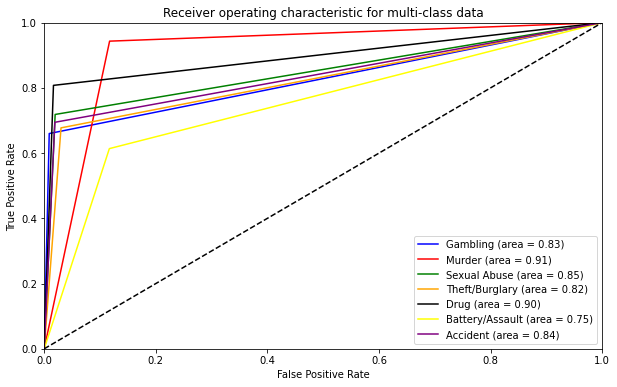

In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt
news_label = ['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault', 'Accident', 'Non-Crime']
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'yellow', 'purple', 'pink', 'grey'])
plt.figure(figsize=(10,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'{news_label[i]} (area = {roc_auc[i]:.2f})')
#     plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'ROC curve of class {news_label[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
Confusion_Matrix_Result = multilabel_confusion_matrix(y_test,result)

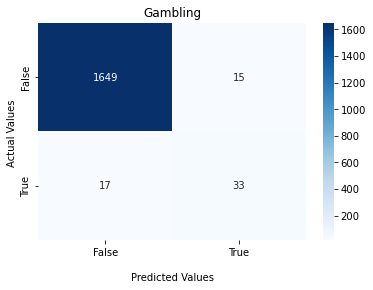

In [ ]:
import seaborn as sns

ax = sns.heatmap(Confusion_Matrix_Result[0], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[0]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

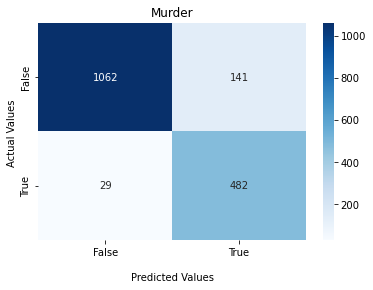

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[1], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[1]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

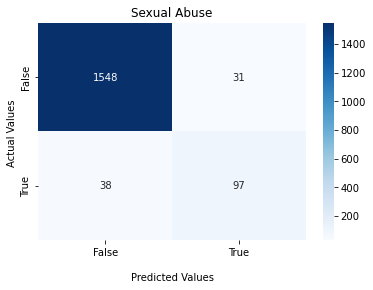

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[2], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[2]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

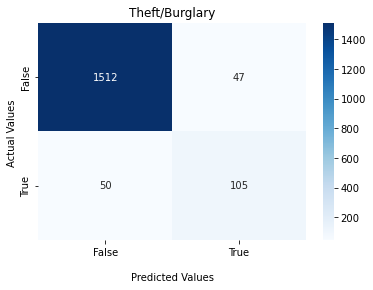

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[3], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[3]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

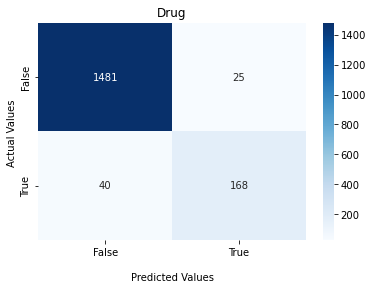

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[4], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[4]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

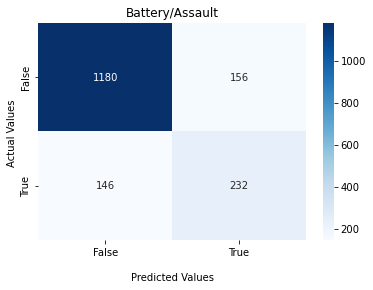

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[5], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[5]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

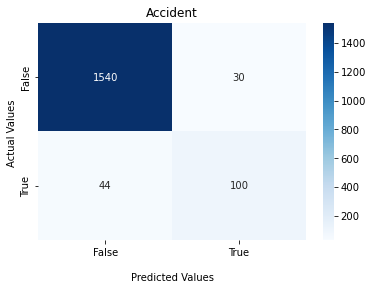

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[6], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[6]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

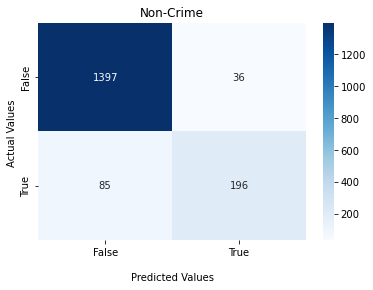

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[7], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[7]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()